In [51]:
import os
from sam import chdir_to_repopath
chdir_to_repopath()
from sam.dose_reponse_fit import dose_response_fit, ModelPredictions, survival_to_stress, FitSettings, Transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sam.data_formats import read_data, load_files, load_datapoints
from sam.plotting import plot_fit_prediction
from sam.system_stress import pred_surv_without_hormesis
from sam.helpers import detect_hormesis_index, pad_c0, compute_lc_from_curve, weibull_2param, weibull_2param_inverse, compute_lc, ll5_inv
from sam.data_formats import ExperimentData
from scipy.optimize import brentq
import seaborn as sns
from sam.stress_addition_model import OLD_STANDARD, sam_prediction, get_sam_lcs, stress_to_survival, survival_to_stress

In [72]:
ignore = [
    "huang_Flupyradifurone_2023",
    "imrana_copper_2024",
    "ayesha_chlorantran_2022_reference",
    "ayesha_chlorantran_2022_agriculture",
    "imrana_salt_2024",
    "naemm_Clothianidin_2024_reference",
]
ingnore = []

filter_func = lambda path: not any(i in path for i in ignore)

In [73]:
def predict_cleaned_curv(data : ExperimentData):
    
    
    
    concentration = pad_c0(data.main_series.concentration).copy()
    survival_tox_observerd = np.copy(data.main_series.survival_rate / data.meta.max_survival)
    
    if data.meta.hormesis_concentration is None:
    
        hormesis_index = detect_hormesis_index(survival_tox_observerd)
        
        if hormesis_index is None:
            hormesis_index = 1
    
    else:
        hormesis_index = np.argwhere(data.meta.hormesis_concentration == data.main_series.concentration)[0,0]
    
    func, _, popt = pred_surv_without_hormesis(concentration=concentration, surv_withhormesis=survival_tox_observerd, hormesis_index=hormesis_index)
    
    return func, hormesis_index, popt

def compute_normalised_curve(model : ModelPredictions):
    
    if np.isnan(model.lc1):
        print("nan")
        model.lc1 = 0.0
    x = np.linspace(model.lc1, model.lc99, 1000)
    
    return model.model(x) * 100

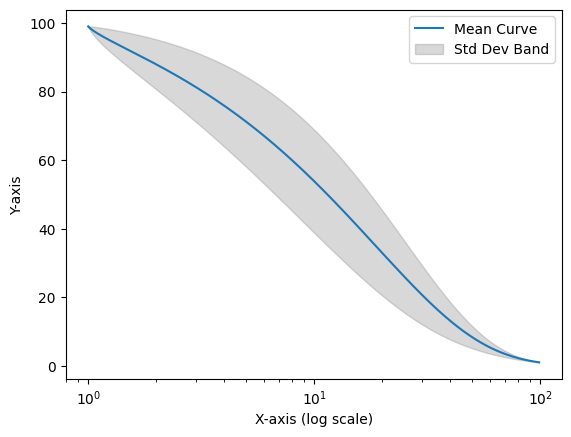

In [87]:
curves = []

for path, data in load_files(filter_func):
    
    cleaned_func, hormesis_index, popt = predict_cleaned_curv(data)
    inverse = lambda x: weibull_2param_inverse(x, *popt)
    def find_lc(lc):
        lc = 1 - lc/100
        return inverse(lc)
    
    lc1 = find_lc(1)
    lc99 = find_lc(99)

    dose = np.linspace(lc1, lc99, 10000)
    
    curves.append(cleaned_func(dose) * 100)

mean_curve = np.stack(curves).mean(0)
std_curve = np.stack(curves).std(0)
lower_band = mean_curve - std_curve
upper_band = mean_curve + std_curve

dose = np.linspace(1, 99, 10000)

plt.plot(dose, mean_curve, label="Mean Curve")
plt.fill_between(dose, lower_band, upper_band, color='gray', alpha=0.3, label="Std Dev Band")

plt.xscale("log")
plt.xlabel('X-axis (log scale)')
plt.ylabel('Y-axis')
plt.legend()
plt.show()

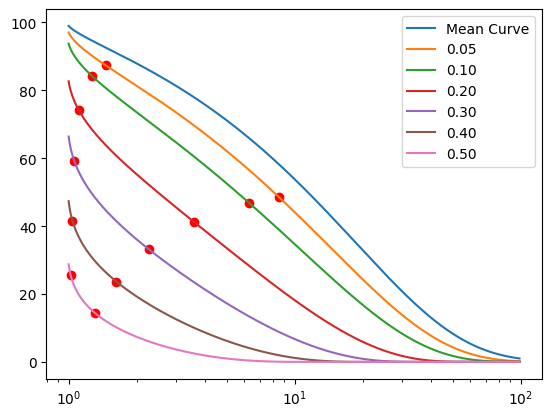

In [89]:
def get_sam_curve(stress :float, curve = mean_curve) -> np.ndarray:
    
    return stress_to_survival( survival_to_stress(curve / 100) + stress) * 100

def compute_lc_new(survival_curve: np.ndarray, lc : float):
    
    
    normed = survival_curve / 100
    normed /= normed.max()
    
    val = 1 - (lc / 100)
    
    arg = np.argmax(normed < val)
    if arg == 0: 
        return np.nan
    
    return float(dose[arg])


stresses = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

plt.plot(dose, mean_curve, label="Mean Curve")

for stress in stresses:
    curve = get_sam_curve(stress)
    plt.plot(dose, curve, label=f"{stress:.2f}")
    
    lc10, lc50 = compute_lc_new(curve, 10), compute_lc_new(curve, 50)
    def find_y(x_val):
        closest = curve[np.argmin(np.abs(x_val - dose))]
        return closest
    
    plt.scatter([lc10, lc50], [find_y(lc10), find_y(lc50)], color = "red")
    
plt.xscale("log")
plt.legend()
plt.show()

In [95]:
lc10s, lc50s = [], []
from tqdm import tqdm

stresses = np.linspace(0, 0.6, 100)
curves = [mean_curve, lower_band, upper_band]

for stress in tqdm(stresses):

    def calc(curve):
        c = get_sam_curve(stress)
        return [compute_lc_new(c, 10), compute_lc_new(c, 50)]

    vals = np.array([calc(curve) for curve in curves])

    lc10s.append(vals[:,0])
    lc50s.append(vals[:,1])

orig10 = np.array([compute_lc_new(c, 10) for c in curves])
orig50 = np.array([compute_lc_new(c, 50) for c in curves])
ten = orig10[None,:] / np.array(lc10s)
fif = orig50[None,:] / np.array(lc50s)
print(orig10, orig50)

100%|██████████| 100/100 [00:29<00:00,  3.44it/s]

[1.85268527 1.3920392  3.63646365] [11.63406341  6.84138414 17.94589459]


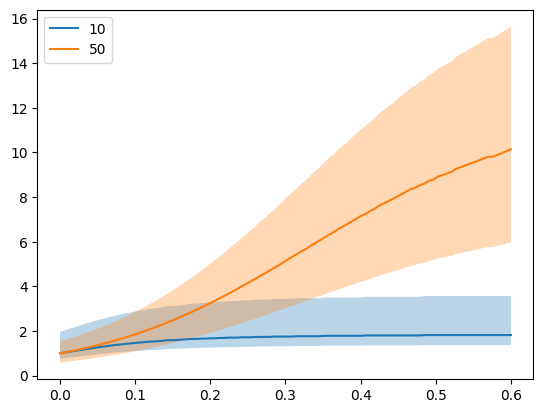

In [98]:


plt.plot(stresses, ten[:,0], label = "10")
plt.fill_between(stresses, ten[:,1], ten[:,2], alpha=0.3)

plt.plot(stresses, fif[:,0], label = "50")
plt.fill_between(stresses, fif[:,1], fif[:,2], alpha=0.3)


plt.legend()

In [84]:
dfs = []


for path, data, stress_name, stress_series in load_datapoints(filter=filter_func):
    meta = data.meta

    main_fit, stress_fit, sam_sur, sam_stress, additional_stress = sam_prediction(
        data.main_series,
        stress_series,
        data.meta,
        settings=OLD_STANDARD,
    )

    lcs = get_sam_lcs(stress_fit=stress_fit, sam_sur=sam_sur, meta=data.meta)
    
    main_lc10 = compute_lc(optim_param=main_fit.optim_param, lc=10)
    main_lc50 = compute_lc(optim_param=main_fit.optim_param, lc=50)

    dfs.append(
        {
            "title": path[:-4],
            "chemical": meta.chemical,
            "organism": meta.organism,
            "main_fit": main_fit,
            "stress_fit": stress_fit,
            "stress_name": stress_name,
            "main_lc10":main_lc10,
            "main_lc50":main_lc50,
            "stress_lc10" : lcs.stress_lc10,
            "stress_lc50" : lcs.stress_lc50,
            "sam_lc10" : lcs.sam_lc10,
            "sam_lc50" : lcs.sam_lc50,
        }
    )

df = pd.DataFrame(dfs)
df.head()

,title,chemical,organism,main_fit,stress_fit,stress_name,main_lc10,main_lc50,stress_lc10,stress_lc50,sam_lc10,sam_lc50
0,/home/felix/Desktop/sam/data/naeem_Esfenvalera...,Esfenvalerate,Daphnia magna,ModelPredictions(concentration_curve=array([1....,ModelPredictions(concentration_curve=array([1....,Prochloraz_1,0.034669,0.435088,0.076167,0.550485,0.034712,0.435554
1,/home/felix/Desktop/sam/data/naeem_Esfenvalera...,Esfenvalerate,Daphnia magna,ModelPredictions(concentration_curve=array([1....,ModelPredictions(concentration_curve=array([1....,Prochloraz_32,0.034669,0.435088,0.024155,0.185064,0.000886,0.079306
2,/home/felix/Desktop/sam/data/naeem_Esfenvalera...,Esfenvalerate,Daphnia magna,ModelPredictions(concentration_curve=array([1....,ModelPredictions(concentration_curve=array([1....,Prochloraz_100,0.034669,0.435088,0.005580,0.152430,0.000886,0.079306
3,/home/felix/Desktop/sam/data/naeem_Esfenvalera...,Esfenvalerate,Daphnia magna,ModelPredictions(concentration_curve=array([1....,ModelPredictions(concentration_curve=array([1....,Food_1%,0.034669,0.435088,0.000269,0.040317,0.000291,0.046408
4,/home/felix/Desktop/sam/data/naeem_Esfenvalera...,Esfenvalerate,Daphnia magna,ModelPredictions(concentration_curve=array([1....,ModelPredictions(concentration_curve=array([1....,Food_1% + Prochloraz_1,0.034669,0.435088,0.000480,0.038849,0.000011,0.006621


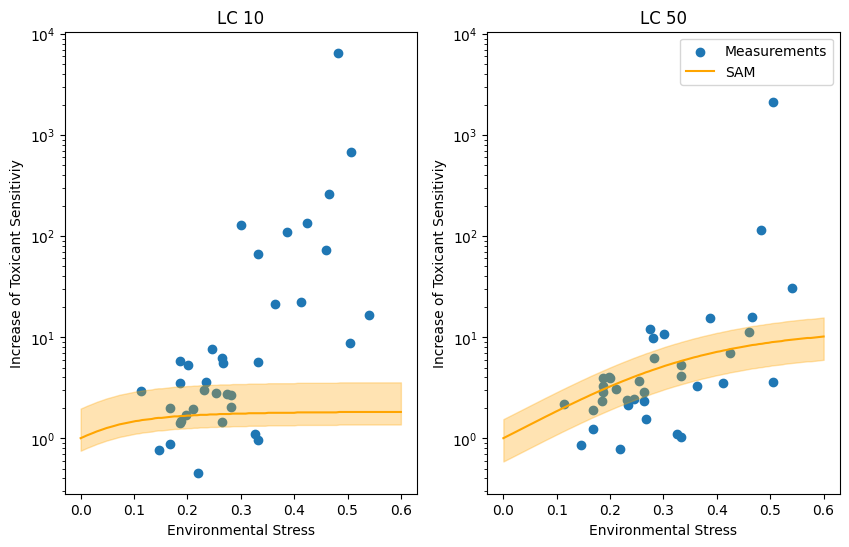

In [100]:
df["true_10_frac"] = df.main_lc10 / df.stress_lc10
df["true_50_frac"] = df.main_lc50 / df.stress_lc50
# df["sam_10_frac"] = df.main_lc10 / df.sam_lc10
# df["sam_50_frac"] = df.main_lc50 / df.sam_lc50

df["stress_level"] = df.stress_fit.apply(lambda x: survival_to_stress(x.optim_param["d"]))


y_name = "Increase of Toxicant Sensitiviy"
x_name = "Environmental Stress"

plt.figure(figsize=(10,6))
ax1 = plt.subplot(1,2,1)
plt.title("LC 10")
plt.scatter(df.stress_level, df["true_10_frac"], label = "Measurements")


plt.plot(stresses, ten[:,0], label = "SAM", color = "orange")
plt.fill_between(stresses, ten[:,1], ten[:,2], alpha=0.3, color = "orange")

plt.yscale("log")
plt.xlabel(x_name)
plt.ylabel(y_name)

plt.subplot(1,2,2, sharey = ax1)
plt.title("LC 50")

plt.scatter(df.stress_level, df["true_50_frac"], label = "Measurements")
plt.plot(stresses, fif[:,0], label = "SAM", color = "orange")
plt.fill_between(stresses, fif[:,1], fif[:,2], alpha=0.3, color = "orange")


plt.yscale("log")
plt.xlabel(x_name)
plt.ylabel(y_name)

plt.legend()
plt.show()